<a href="https://colab.research.google.com/github/sincereQK/QK-ML-Data-study/blob/main/stock_LSTM_20250905.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install tensorflow scikit-learn pandas numpy matplotlib pandas-ta

In [1]:
pip install pandas-ta

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0804
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0196
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0089
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0079
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0067
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0058
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0053
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0060
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0057
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0052
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0056
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0050
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0039
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0042
Epoc

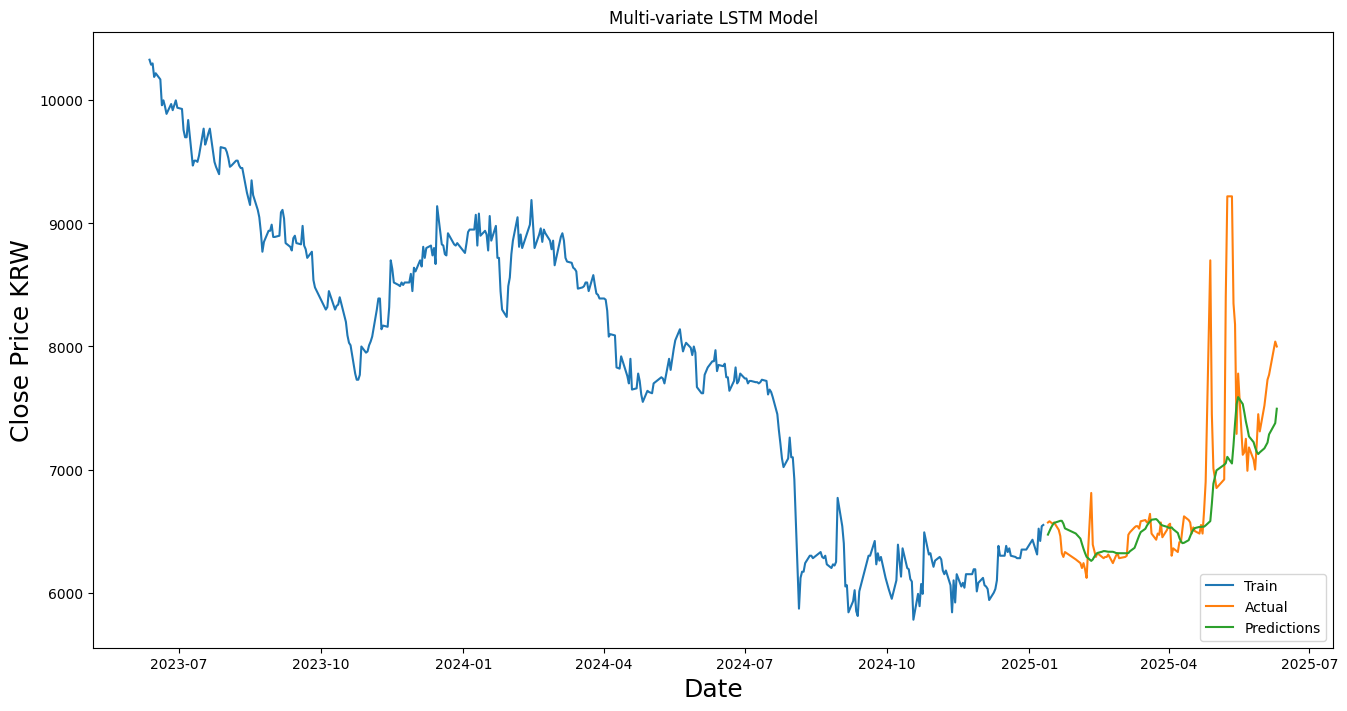

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 전처리
# /content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv')
# df = pd.read_csv('20230610_20250610_일봉_000050_경방.csv')

# '일자'를 datetime 형식으로 변환하고 오름차순으로 정렬
df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df = df.sort_values('일자').reset_index(drop=True)

# 예측에 사용할 5가지 변수 선택
features = ['시가', '고가', '저가', '현재가', '거래량']
data = df[features]

# 데이터 정규화 (0과 1 사이로 스케일링)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_data_len = int(np.ceil(len(scaled_data) * 0.8))

# 학습 데이터셋 생성
train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []
look_back = 60 # 과거 60일의 데이터를 기반으로 예측

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, :]) # 5가지 변수 모두 입력
    y_train.append(train_data[i, 3]) # 예측 대상은 '현재가' (4번째 열, 인덱스 3)

x_train, y_train = np.array(x_train), np.array(y_train)

# 2. LSTM 모델 구축
model = Sequential()
# 입력 형태에 변수의 개수(5)를 반영
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. 모델 학습
model.fit(x_train, y_train, batch_size=32, epochs=50)

# 4. 테스트 데이터셋 생성 및 예측
test_data = scaled_data[train_data_len - look_back:, :]
x_test = []
y_test = df['현재가'][train_data_len:].values # 실제 현재가

for i in range(look_back, len(test_data)):
    x_test.append(test_data[i-look_back:i, :])

x_test = np.array(x_test)

predictions_scaled = model.predict(x_test)

# 예측값을 원래 스케일로 되돌리기 위한 처리
# Scaler는 5개의 변수에 대해 학습되었으므로, 예측값(1개)을 다시 5개 변수 형태로 만들어 inverse_transform을 적용해야 함
dummy_predictions = np.zeros((len(predictions_scaled), 5))
dummy_predictions[:, 3] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_predictions)[:, 3]


# 5. 결과 시각화
train = df[:train_data_len]
valid = df[train_data_len:].copy() # SettingWithCopyWarning 방지
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Multi-variate LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price KRW', fontsize=18)
plt.plot(train['일자'], train['현재가'])
plt.plot(valid['일자'], valid[['현재가', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.savefig('stock_prediction_multi_v2.png')

# 6. 향후 주가 예측 (마지막 60일 데이터 사용)
last_60_days_scaled = scaled_data[-look_back:]
x_predict = np.reshape(last_60_days_scaled, (1, last_60_days_scaled.shape[0], 5))

predicted_price_scaled = model.predict(x_predict)

# 예측값을 원래 스케일로 되돌리기
dummy_predict = np.zeros((1, 5))
dummy_predict[:, 3] = predicted_price_scaled
predicted_price = scaler.inverse_transform(dummy_predict)[:, 3]

print(f'다음 날 예측 주가: {predicted_price[0]}')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0852
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0156
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0072
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0074
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0058
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0052
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0052
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0045
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0051
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0047
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0050
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0048
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0048
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0046
Epoc

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
다음 날 예측 주가: 7676.7834413051605


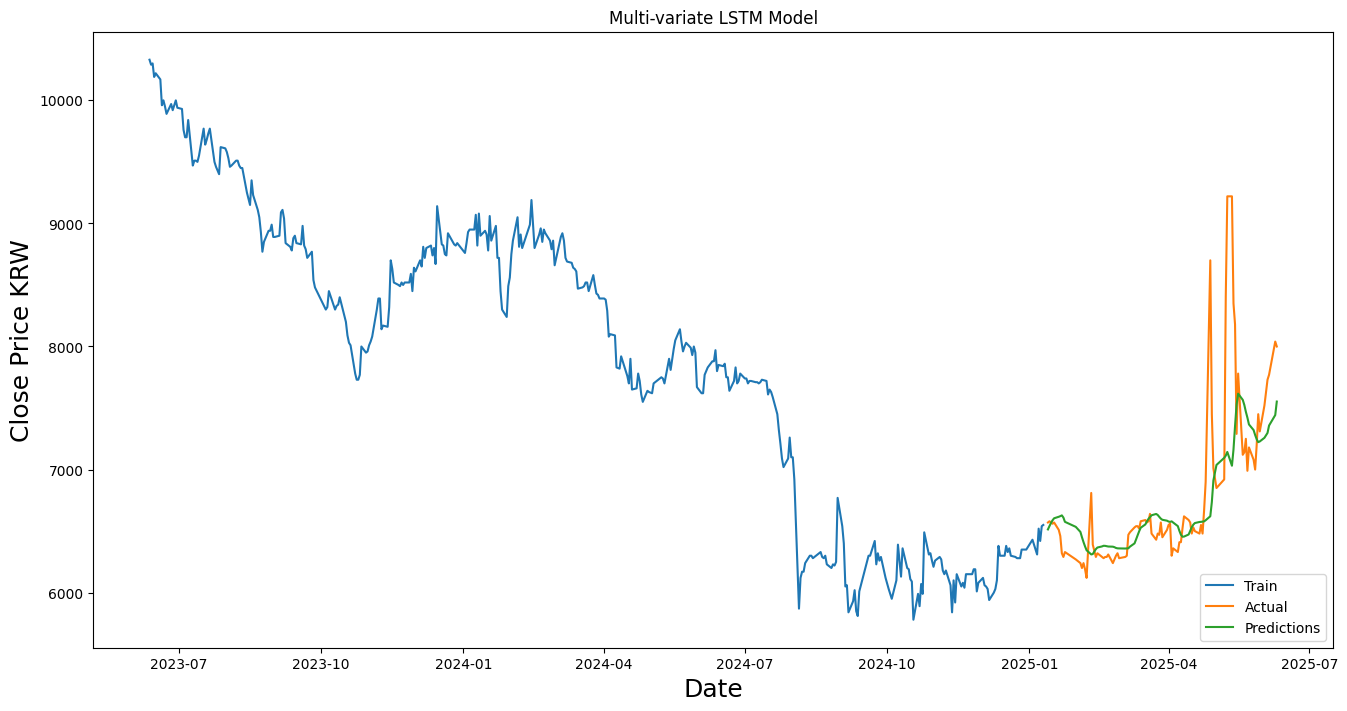

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 전처리
# /content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv')
# df = pd.read_csv('20230610_20250610_일봉_000050_경방.csv')

# '일자'를 datetime 형식으로 변환하고 오름차순으로 정렬
df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df = df.sort_values('일자').reset_index(drop=True)

# 예측에 사용할 5가지 변수 선택
features = ['시가', '고가', '저가', '현재가', '거래량']
data = df[features]

# 데이터 정규화 (0과 1 사이로 스케일링)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_data_len = int(np.ceil(len(scaled_data) * 0.8))

# 학습 데이터셋 생성
train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []
look_back = 60 # 과거 60일의 데이터를 기반으로 예측

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, :]) # 5가지 변수 모두 입력
    y_train.append(train_data[i, 3]) # 예측 대상은 '현재가' (4번째 열, 인덱스 3)

x_train, y_train = np.array(x_train), np.array(y_train)

# 2. LSTM 모델 구축 (Input 레이어 추가)
model = Sequential()
# Input 레이어를 모델의 가장 처음에 추가하여 입력 형태를 명시적으로 정의
model.add(Input(shape=(x_train.shape[1], 5)))
# 기존 LSTM 레이어에서는 input_shape 인자를 제거
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. 모델 학습
model.fit(x_train, y_train, batch_size=32, epochs=50)

# 4. 테스트 데이터셋 생성 및 예측
test_data = scaled_data[train_data_len - look_back:, :]
x_test = []
y_test = df['현재가'][train_data_len:].values # 실제 현재가

for i in range(look_back, len(test_data)):
    x_test.append(test_data[i-look_back:i, :])

x_test = np.array(x_test)

predictions_scaled = model.predict(x_test)

# 예측값을 원래 스케일로 되돌리기 위한 처리
# Scaler는 5개의 변수에 대해 학습되었으므로, 예측값(1개)을 다시 5개 변수 형태로 만들어 inverse_transform을 적용해야 함
dummy_predictions = np.zeros((len(predictions_scaled), 5))
dummy_predictions[:, 3] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_predictions)[:, 3]


# 5. 결과 시각화
train = df[:train_data_len]
valid = df[train_data_len:].copy() # SettingWithCopyWarning 방지
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Multi-variate LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price KRW', fontsize=18)
plt.plot(train['일자'], train['현재가'])
plt.plot(valid['일자'], valid[['현재가', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.savefig('stock_prediction_multi_v2.png')

# 6. 향후 주가 예측 (마지막 60일 데이터 사용)
last_60_days_scaled = scaled_data[-look_back:]
x_predict = np.reshape(last_60_days_scaled, (1, last_60_days_scaled.shape[0], 5))

predicted_price_scaled = model.predict(x_predict)

# 예측값을 원래 스케일로 되돌리기
dummy_predict = np.zeros((1, 5))
dummy_predict[:, 3] = predicted_price_scaled
predicted_price = scaler.inverse_transform(dummy_predict)[:, 3]

print(f'다음 날 예측 주가: {predicted_price[0]}')

기존 방식: Sequential 모델의 첫 번째 레이어(LSTM)에 input_shape를 직접 지정하는 방식입니다.

권장 방식: 모델의 첫 번째 레이어로 Input 객체를 명시적으로 추가하여, 모델이 어떤 형태의 데이터를 입력받는지 명확하게 정의하는 방식입니다.

In [ ]:
# 오류 수정전의 코드 입니다.
# !pip install pandas-ta # 이 라이브러리가 없다면 주석을 해제하고 실행하여 설치하세요.

import pandas as pd
import numpy as np
import pandas_ta as ta # 기술적 지표 계산을 위한 라이브러리
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

# --- 1. 데이터 불러오기 및 정렬 ---
df = pd.read_csv('20230610_20250610_일봉_000050_경방.csv')
df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df = df.sort_values('일자').reset_index(drop=True)

# --- 2. 기술적 지표(SMA, RSI) 계산 ---
print("기술적 지표(SMA, RSI)를 계산합니다...")
df['sma20'] = ta.sma(df['현재가'], length=20)
df['rsi14'] = ta.rsi(df['현재가'], length=14)

# 지표 계산 초기에 발생하는 NaN 값들을 제거 (데이터 정합성)
df.dropna(inplace=True)
df = df.reset_index(drop=True)

# --- 3. 계산된 지표를 포함한 데이터를 새 CSV 파일로 저장 ---
new_csv_filename = 'stock_data_with_indicators.csv'
print(f"계산된 지표를 '{new_csv_filename}' 파일로 저장합니다.")
df.to_csv(new_csv_filename, index=False, encoding='utf-8-sig')

# --- 4. 모델 학습을 위한 데이터 전처리 ---
features = ['시가', '고가', '저가', '현재가', '거래량', 'sma20', 'rsi14']
data = df[features].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --- 5. 모델 학습 데이터셋 생성 ---
train_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:train_data_len, :]
x_train, y_train = [], []
look_back = 60

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, :])
    y_train.append(train_data[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)

# --- 6. LSTM 모델 구축 및 학습 ---
print("LSTM 모델 학습을 시작합니다...")
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

# --- 7. 다음 날 주가 예측 ---
last_60_days_scaled = scaled_data[-look_back:]
x_predict = np.reshape(last_60_days_scaled, (1, look_back, len(features)))
predicted_price_scaled = model.predict(x_predict)

dummy_predict = np.zeros((1, len(features)))
dummy_predict[:, 3] = predicted_price_scaled
predicted_price = scaler.inverse_transform(dummy_predict)[:, 3][0]

# --- 8. 매매 신호 판단 ---
latest_data = df.iloc[-1]
current_price = latest_data['현재가']
current_sma20 = latest_data['sma20']
current_rsi14 = latest_data['rsi14']

print("\n--- 매매 신호 판단 ---")
print(f"현재 가격: {current_price:,.0f}원")
print(f"다음 날 예측 가격: {predicted_price:,.0f}원")
print(f"현재 20일 이동평균선: {current_sma20:,.0f}원")
print(f"현재 RSI14: {current_rsi14:.2f}")
print("--------------------")

def get_trading_signal(predicted, current, sma20, rsi14):
    is_buy_signal = (predicted > current * 1.02 and current > sma20 and rsi14 < 70)
    is_sell_signal = (predicted < current * 0.98)

    if is_buy_signal:
        print("판단: 매수 신호")
        return 1
    elif is_sell_signal:
        print("판단: 매도 신호")
        return 0
    else:
        print("판단: 관망 (매매 신호 없음)")
        return None

signal = get_trading_signal(predicted_price, current_price, current_sma20, current_rsi14)
print(f"\n최종 출력: {signal}")

In [5]:
# !pip install pandas-ta # pandas-ta는 sma와 rsi를 계산하기 위해서 사용하는 라이브러리

import pandas as pd
import numpy as np
import pandas_ta as ta # 기술적 지표 계산을 위한 라이브러리
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input


# 1. 데이터 불러오기 및 전처리
# /content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv')
# df = pd.read_csv('20230610_20250610_일봉_000050_경방.csv')

df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df = df.sort_values('일자').reset_index(drop=True)

# --- 2. 기술적 지표(SMA, RSI) 계산 ---
print("기술적 지표(SMA, RSI)를 계산합니다...")
df['sma20'] = ta.sma(df['현재가'], length=20)
df['rsi14'] = ta.rsi(df['현재가'], length=14)

# --- 3. 결측값 처리 (수정된 부분) ---
# 'sma20'과 'rsi14' 열에 결측값이 있는 행만 삭제하여 다른 열의 결측값 문제를 회피합니다.
df.dropna(subset=['sma20', 'rsi14'], inplace=True)
df = df.reset_index(drop=True)

# --- 4. 모델 학습을 위한 데이터 전처리 ---
features = ['시가', '고가', '저가', '현재가', '거래량', 'sma20', 'rsi14']
data = df[features].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --- 5. 모델 학습 데이터셋 생성 ---
train_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:train_data_len, :]
x_train, y_train = [], []
look_back = 60

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, :])
    y_train.append(train_data[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)

# --- 6. LSTM 모델 구축 및 학습 ---
print("LSTM 모델 학습을 시작합니다...")
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1) # epochs 원복

# --- 7. 다음 날 주가 예측 ---
last_60_days_scaled = scaled_data[-look_back:]
x_predict = np.reshape(last_60_days_scaled, (1, look_back, len(features)))
predicted_price_scaled = model.predict(x_predict)

dummy_predict = np.zeros((1, len(features)))
dummy_predict[:, 3] = predicted_price_scaled
predicted_price = scaler.inverse_transform(dummy_predict)[:, 3][0]

# --- 8. 매매 신호 판단 ---
latest_data = df.iloc[-1]
current_price = latest_data['현재가']
current_sma20 = latest_data['sma20']
current_rsi14 = latest_data['rsi14']

print("\n--- 매매 신호 판단 ---")
print(f"현재 가격: {current_price:,.0f}원")
print(f"다음 날 예측 가격: {predicted_price:,.0f}원")
print(f"현재 20일 이동평균선: {current_sma20:,.0f}원")
print(f"현재 RSI14: {current_rsi14:.2f}")
print("--------------------")

def get_trading_signal(predicted, current, sma20, rsi14):
    is_buy_signal = (predicted > current * 1.02 and current > sma20 and rsi14 < 70)
    is_sell_signal = (predicted < current * 0.98)

    if is_buy_signal:
        print("판단: 매수 신호")
        return 1
    elif is_sell_signal:
        print("판단: 매도 신호")
        return 0
    else:
        print("판단: 관망 (매매 신호 없음)")
        return None

signal = get_trading_signal(predicted_price, current_price, current_sma20, current_rsi14)
print(f"\n최종 출력: {signal}")

기술적 지표(SMA, RSI)를 계산합니다...
LSTM 모델 학습을 시작합니다...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0977
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0139
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0118
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0107
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0081
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0070
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0054
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0071
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0067
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0058
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0048
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0046
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0053
Epoch 15/50
10/10 ━━━━━

In [6]:
# !pip install pandas-ta

import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

# 1. 데이터 불러오기 및 전처리
# /content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20230610_20250610_일봉_000050_경방.csv')
# df = pd.read_csv('20230610_20250610_일봉_000050_경방.csv')

df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df = df.sort_values('일자').reset_index(drop=True)

# --- 2. 기술적 지표(SMA, RSI) 계산 ---
print("기술적 지표(SMA, RSI)를 계산합니다...")
df['sma20'] = ta.sma(df['현재가'], length=20)
df['rsi14'] = ta.rsi(df['현재가'], length=14)

# --- 3. 결측값 처리 (수정된 부분) ---
# 'sma20'과 'rsi14' 열에 결측값이 있는 행만 삭제하여 다른 열의 결측값 문제를 회피합니다.
df.dropna(subset=['sma20', 'rsi14'], inplace=True)
df = df.reset_index(drop=True)

# --- 4. 모델 학습을 위한 데이터 전처리 ---
features = ['시가', '고가', '저가', '현재가', '거래량', 'sma20', 'rsi14']
data = df[features].copy()

# 이 부분에서 오류가 발생했었음
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --- 5. 모델 학습 데이터셋 생성 ---
train_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:train_data_len, :]
x_train, y_train = [], []
look_back = 60

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, :])
    y_train.append(train_data[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)

# --- 6. LSTM 모델 구축 및 학습 ---
print("LSTM 모델 학습을 시작합니다...")
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1) # epochs 원복

# --- 7. 다음 날 주가 예측 ---
last_60_days_scaled = scaled_data[-look_back:]
x_predict = np.reshape(last_60_days_scaled, (1, look_back, len(features)))
predicted_price_scaled = model.predict(x_predict)

dummy_predict = np.zeros((1, len(features)))
dummy_predict[:, 3] = predicted_price_scaled
predicted_price = scaler.inverse_transform(dummy_predict)[:, 3][0]

# --- 8. 매매 신호 판단 ---
latest_data = df.iloc[-1]
current_price = latest_data['현재가']
current_sma20 = latest_data['sma20']
current_rsi14 = latest_data['rsi14']

print("\n--- 매매 신호 판단 ---")
print(f"현재 가격: {current_price:,.0f}원")
print(f"다음 날 예측 가격: {predicted_price:,.0f}원")
print(f"현재 20일 이동평균선: {current_sma20:,.0f}원")
print(f"현재 RSI14: {current_rsi14:.2f}")
print("--------------------")

def get_trading_signal(predicted, current, sma20, rsi14):
    is_buy_signal = (predicted > current * 1.02 and current > sma20 and rsi14 < 70)
    is_sell_signal = (predicted < current * 0.98)

    if is_buy_signal:
        print("판단: 매수 신호")
        return 1
    elif is_sell_signal:
        print("판단: 매도 신호")
        return 0
    else:
        print("판단: 관망 (매매 신호 없음)")
        return None

signal = get_trading_signal(predicted_price, current_price, current_sma20, current_rsi14)
print(f"\n최종 출력: {signal}")

기술적 지표(SMA, RSI)를 계산합니다...
LSTM 모델 학습을 시작합니다...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1355
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0136
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0101
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0088
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0086
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0089
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0078
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0050
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0080
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0052
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0048
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0047
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0050
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0044
Epoch 15/50
10/10 ━━━━━

In [8]:
# 매매판단에 sma와 rsi를 추가
# --- 9. 최종 매매 신호 결정 및 출력 ---
print("\n--- 매매 신호 판단 ---")
print(f"현재 가격: {current_price:,.0f}원")
print(f"다음 날 예측 가격: {predicted_price:,.0f}원")
print(f"현재 20일 이동평균선: {current_sma20:,.0f}원")
print(f"현재 RSI14: {current_rsi14:.2f}")
print("--------------------")

def get_trading_signal(predicted, current, sma20, rsi14):
    """
    설명된 매매 전략에 따라 매수(1), 매도(0), 보류(None) 신호를 반환합니다.
    """
    # 매수 조건: 3가지 조건을 모두 만족해야 함
    is_buy_signal = (
        predicted > current * 1.02 and  # 조건1: 2% 이상 상승 예측
        current > sma20 and              # 조건2: 상승 추세 (현재가가 20일선 위)
        rsi14 < 70                       # 조건3: 과매수 상태 아님 (RSI < 70)
    )

    # 매도 조건
    is_sell_signal = (
        predicted < current * 0.98     # 조건1: 2% 이상 하락 예측
    )

    if is_buy_signal:
        print("판단: 매수 신호")
        return 1
    elif is_sell_signal:
        print("판단: 매도 신호")
        return 0
    else:
        print("판단: 관망 (매매 신호 없음)")
        return None

# 최종 신호 출력
signal = get_trading_signal(predicted_price, current_price, current_sma20, current_rsi14)
print(f"\n최종 출력: {signal}")



--- 매매 신호 판단 ---
현재 가격: 8,000원
다음 날 예측 가격: 7,435원
현재 20일 이동평균선: 7,580원
현재 RSI14: 58.34
--------------------
판단: 매도 신호

최종 출력: 0
